In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import torch
torch.cuda.empty_cache()


In [3]:
pip install torch torchvision timm opencv-python scikit-learn einops


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

class VideoDeepfakeDataset(Dataset):
    def __init__(self, real_dir, fake_dir, num_frames=16, img_size=224):
        self.samples = []
        self.num_frames = num_frames

        for v in os.listdir(real_dir):
            self.samples.append((os.path.join(real_dir, v), 0))
        for v in os.listdir(fake_dir):
            self.samples.append((os.path.join(fake_dir, v), 1))

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def load_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        idxs = np.linspace(0, total-1, self.num_frames).astype(int)

        for i in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(self.transform(frame))
        cap.release()
        return torch.stack(frames)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        video = self.load_video(path)
        return video, label


In [3]:
import torch.nn as nn
from einops import rearrange

class MultiScaleAttention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.attn1 = nn.MultiheadAttention(dim, heads)
        self.attn2 = nn.MultiheadAttention(dim, heads)
        self.attn3 = nn.MultiheadAttention(dim, heads)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        a1,_ = self.attn1(x, x, x)
        a2,_ = self.attn2(x[::2], x[::2], x[::2])
        a3,_ = self.attn3(x[::4], x[::4], x[::4])

        a2 = torch.repeat_interleave(a2, 2, dim=0)[:x.size(0)]
        a3 = torch.repeat_interleave(a3, 4, dim=0)[:x.size(0)]

        return self.norm(x + a1 + a2 + a3)


In [4]:
import timm

class ViTMultiScale(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = timm.create_model(
            'vit_base_patch16_224',
            pretrained=True,
            num_classes=0
        )
        self.msa = MultiScaleAttention(768)
        self.classifier = nn.Linear(768, 1)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        feats = self.vit(x)
        feats = feats.view(B, T, -1)

        feats = rearrange(feats, 'b t d -> t b d')
        feats = self.msa(feats)
        feats = feats.mean(dim=0)

        return self.classifier(feats).squeeze(1)


In [5]:
import torch.optim as optim

model = ViTMultiScale().cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

def train_epoch(loader):
    model.train()
    for x,y in loader:
        x,y = x.cuda(), y.float().cuda()
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()


In [6]:
from sklearn.metrics import (
    roc_auc_score, f1_score, recall_score,
    precision_score, confusion_matrix
)

def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x,y in loader:
            x = x.cuda()
            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy()
            y_pred.extend(probs)
            y_true.extend(y.numpy())

    y_bin = (np.array(y_pred) > 0.5).astype(int)

    auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_bin)
    recall = recall_score(y_true, y_bin)
    precision = precision_score(y_true, y_bin)
    cm = confusion_matrix(y_true, y_bin)

    return auc, f1, recall, precision, cm


In [11]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

REAL_DIR = r"C:\Users\EliteLaptop\Desktop\kawtar\GAN_inversion\raw\real"
FAKE_DIR = r"C:\Users\EliteLaptop\Desktop\kawtar\GAN_inversion\raw\fake200"

dataset = VideoDeepfakeDataset(
    REAL_DIR,
    FAKE_DIR,
    num_frames=16,
    img_size=224
)

indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=[dataset.samples[i][1] for i in indices]
)

train_loader = DataLoader(
    torch.utils.data.Subset(dataset, train_idx),
    batch_size=2,   # ViT video is GPU-heavy
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    torch.utils.data.Subset(dataset, val_idx),
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


In [12]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
EPOCHS = 20
best_auc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")

    model.train()
    running_loss = 0.0

    train_bar = tqdm(
        train_loader,
        desc=f"Train Epoch {epoch+1}",
        leave=False
    )

    for x, y in train_bar:
        x = x.cuda(non_blocking=True)
        y = y.float().cuda(non_blocking=True)

        optimizer.zero_grad()

        with autocast():
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        train_bar.set_postfix({
            "loss": f"{loss.item():.4f}"
        })

    avg_loss = running_loss / len(train_loader)
    print(f"Train Loss: {avg_loss:.4f}")

    # ---------- VALIDATION ----------
    auc, f1, recall, precision, cm = evaluate(val_loader)

    print(f"AUC: {auc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f}")
    print("Confusion Matrix:")
    print(cm)

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "vit_multiscale_best.pth")
        print("✔ Best model saved")


C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch [1/20]


Train Epoch 1:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.5896
AUC: 0.9103 | F1: 0.8302 | Recall: 0.9565 | Precision: 0.7333
Confusion Matrix:
[[31 16]
 [ 2 44]]
✔ Best model saved

Epoch [2/20]


Train Epoch 2:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.4310
AUC: 0.9394 | F1: 0.8235 | Recall: 0.7609 | Precision: 0.8974
Confusion Matrix:
[[43  4]
 [11 35]]
✔ Best model saved

Epoch [3/20]


Train Epoch 3:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.3676
AUC: 0.9218 | F1: 0.9072 | Recall: 0.9565 | Precision: 0.8627
Confusion Matrix:
[[40  7]
 [ 2 44]]

Epoch [4/20]


Train Epoch 4:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.3224
AUC: 0.9334 | F1: 0.9032 | Recall: 0.9130 | Precision: 0.8936
Confusion Matrix:
[[42  5]
 [ 4 42]]

Epoch [5/20]


Train Epoch 5:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.2420
AUC: 0.9163 | F1: 0.8932 | Recall: 1.0000 | Precision: 0.8070
Confusion Matrix:
[[36 11]
 [ 0 46]]

Epoch [6/20]


Train Epoch 6:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.2132
AUC: 0.9468 | F1: 0.6571 | Recall: 0.5000 | Precision: 0.9583
Confusion Matrix:
[[46  1]
 [23 23]]
✔ Best model saved

Epoch [7/20]


Train Epoch 7:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.2809
AUC: 0.9413 | F1: 0.8864 | Recall: 0.8478 | Precision: 0.9286
Confusion Matrix:
[[44  3]
 [ 7 39]]

Epoch [8/20]


Train Epoch 8:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.2136
AUC: 0.9334 | F1: 0.9149 | Recall: 0.9348 | Precision: 0.8958
Confusion Matrix:
[[42  5]
 [ 3 43]]

Epoch [9/20]


Train Epoch 9:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1676
AUC: 0.9399 | F1: 0.5588 | Recall: 0.4130 | Precision: 0.8636
Confusion Matrix:
[[44  3]
 [27 19]]

Epoch [10/20]


Train Epoch 10:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.2324
AUC: 0.9241 | F1: 0.8866 | Recall: 0.9348 | Precision: 0.8431
Confusion Matrix:
[[39  8]
 [ 3 43]]

Epoch [11/20]


Train Epoch 11:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1590
AUC: 0.9440 | F1: 0.8936 | Recall: 0.9130 | Precision: 0.8750
Confusion Matrix:
[[41  6]
 [ 4 42]]

Epoch [12/20]


Train Epoch 12:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1635
AUC: 0.9454 | F1: 0.8636 | Recall: 0.8261 | Precision: 0.9048
Confusion Matrix:
[[43  4]
 [ 8 38]]

Epoch [13/20]


Train Epoch 13:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.2014
AUC: 0.9482 | F1: 0.9362 | Recall: 0.9565 | Precision: 0.9167
Confusion Matrix:
[[43  4]
 [ 2 44]]
✔ Best model saved

Epoch [14/20]


Train Epoch 14:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1102
AUC: 0.9362 | F1: 0.8936 | Recall: 0.9130 | Precision: 0.8750
Confusion Matrix:
[[41  6]
 [ 4 42]]

Epoch [15/20]


Train Epoch 15:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1222
AUC: 0.9265 | F1: 0.8738 | Recall: 0.9783 | Precision: 0.7895
Confusion Matrix:
[[35 12]
 [ 1 45]]

Epoch [16/20]


Train Epoch 16:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1518
AUC: 0.9426 | F1: 0.8738 | Recall: 0.9783 | Precision: 0.7895
Confusion Matrix:
[[35 12]
 [ 1 45]]

Epoch [17/20]


Train Epoch 17:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0610
AUC: 0.9334 | F1: 0.8911 | Recall: 0.9783 | Precision: 0.8182
Confusion Matrix:
[[37 10]
 [ 1 45]]

Epoch [18/20]


Train Epoch 18:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0208
AUC: 0.9417 | F1: 0.8776 | Recall: 0.9348 | Precision: 0.8269
Confusion Matrix:
[[38  9]
 [ 3 43]]

Epoch [19/20]


Train Epoch 19:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0596
AUC: 0.9209 | F1: 0.8046 | Recall: 0.7609 | Precision: 0.8537
Confusion Matrix:
[[41  6]
 [11 35]]

Epoch [20/20]


Train Epoch 20:   0%|          | 0/185 [00:00<?, ?it/s]C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\4056325147.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1653
AUC: 0.9362 | F1: 0.9167 | Recall: 0.9565 | Precision: 0.8800
Confusion Matrix:
[[41  6]
 [ 2 44]]


In [21]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

REAL_DIR = r"C:\Users\EliteLaptop\Desktop\kawtar\GAN_inversion\raw\real"
FAKE_DIR = r"C:\Users\EliteLaptop\Desktop\kawtar\GAN_inversion\raw\fake200"

dataset = VideoDeepfakeDataset(
    REAL_DIR,
    FAKE_DIR,
    num_frames=16,
    img_size=224
)

indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,           # 20% TEST
    random_state=42,
    stratify=[dataset.samples[i][1] for i in indices]
)


train_loader = DataLoader(
    torch.utils.data.Subset(dataset, train_idx),
    batch_size=2,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    torch.utils.data.Subset(dataset, test_idx),
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)



In [22]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
EPOCHS = 20
best_auc = 0.0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x = x.cuda(non_blocking=True)
        y = y.float().cuda(non_blocking=True)

        optimizer.zero_grad()
        with autocast():
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {running_loss/len(train_loader):.4f}")


model.eval()
auc, f1, recall, precision, cm = evaluate(test_loader)

print("==== FINAL TEST RESULTS ====")
print(f"AUC: {auc:.4f}")
print(f"F1: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print("Confusion Matrix:")
print(cm)




C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\2168609364.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\EliteLaptop\AppData\Local\Temp\ipykernel_13844\2168609364.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Train Loss: 0.5593
Epoch 2 | Train Loss: 0.3752
Epoch 3 | Train Loss: 0.3362
Epoch 4 | Train Loss: 0.2674
Epoch 5 | Train Loss: 0.2409
Epoch 6 | Train Loss: 0.2399
Epoch 7 | Train Loss: 0.2104
Epoch 8 | Train Loss: 0.1802
Epoch 9 | Train Loss: 0.1825
Epoch 10 | Train Loss: 0.1853
Epoch 11 | Train Loss: 0.1531
Epoch 12 | Train Loss: 0.0953
Epoch 13 | Train Loss: 0.1768
Epoch 14 | Train Loss: 0.1839
Epoch 15 | Train Loss: 0.1173
Epoch 16 | Train Loss: 0.1171
Epoch 17 | Train Loss: 0.1096
Epoch 18 | Train Loss: 0.0787
Epoch 19 | Train Loss: 0.1357
Epoch 20 | Train Loss: 0.0502
==== FINAL TEST RESULTS ====
AUC: 0.9519
F1: 0.8571
Recall: 0.8478
Precision: 0.8667
Confusion Matrix:
[[41  6]
 [ 7 39]]


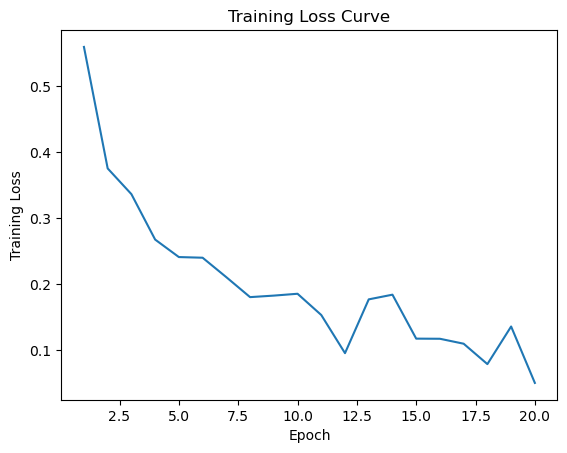

In [1]:
import matplotlib.pyplot as plt

# Assume we stored these during training
train_losses = [0.5593, 0.3752, 0.3362, 0.2674, 0.2409, 0.2399, 0.2104, 0.1802, 0.1825, 0.1853,
                0.1531, 0.0953, 0.1768, 0.1839, 0.1173, 0.1171, 0.1096, 0.0787, 0.1357, 0.0502]
epochs = list(range(1, len(train_losses) + 1))

plt.figure()
plt.plot(epochs, train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.show()
